In [1]:
import numpy as np
import pandas as pd
import random
import os
import time
import pickle
from pathlib import Path
import gc

from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import roc_auc_score

import lightgbm as lgb
#import xgboost as xgb
#import catboost as ctb

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.simplefilter('ignore')

https://www.kaggle.com/hamzaghanmi/tps-oct-lightgbm

ver14

# Parameters

In [2]:
target = 'target'

DEBUG = False

if DEBUG:
    N_ESTIMATORS = 1
    N_SPLITS = 2
    SEED = 2017
    CVSEED = 2017
    EARLY_STOPPING_ROUNDS = 1
    VERBOSE = 100
    #N_ITERS = 2
else:
    N_SPLITS = 5
    N_ESTIMATORS = 20000
    EARLY_STOPPING_ROUNDS = 300
    VERBOSE = 1000
    SEED = 2017
    CVSEED = 2017
    #N_ITERS = 10

In [3]:
def set_seed(seed=2017):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    
set_seed(SEED)

# Datasets

In [4]:
INPUT = Path("../input/tabular-playground-series-oct-2021")

train = pd.read_csv(INPUT / "train.csv")
test = pd.read_csv(INPUT / "test.csv")
submission = pd.read_csv(INPUT / "sample_submission.csv")

In [5]:
train = train[train.columns[1:]]
test = test[test.columns[1:]]

# Preprocessing

In [6]:
features = [col for col in train.columns if 'f' in col]

In [7]:
cont_features =[]
disc_features =[]

for col in features:
    if train[col].dtype=='float64':
        cont_features.append(col)
    else:
        disc_features.append(col)
        
features = disc_features + cont_features

In [8]:
scaler = RobustScaler()
train[cont_features] = scaler.fit_transform(train[cont_features])
test[cont_features] = scaler.transform(test[cont_features])

In [9]:
test[features]

,f22,f43,f242,f243,f244,f245,f246,f247,f248,f249,...,f232,f233,f234,f235,f236,f237,f238,f239,f240,f241
0,0,1,0,0,1,0,1,1,0,0,...,0.176731,5.678981,0.099877,-0.161303,0.663454,0.002586,0.805119,-1.090903,0.506371,-0.910036
1,1,0,0,0,0,1,1,1,0,0,...,-0.410526,0.068038,0.427906,-0.440263,-0.334098,-1.028321,0.683359,-0.040858,-0.592200,-0.129326
2,0,0,0,1,1,1,1,1,0,1,...,0.486981,0.651625,1.863151,0.311898,0.874617,-0.248570,-0.645745,-0.018094,0.824797,0.336295
3,0,0,0,0,0,0,1,1,0,1,...,0.685319,1.069675,1.779975,1.098344,3.327531,0.442740,-0.303592,-0.970196,0.460491,-0.669676
4,1,0,0,1,0,1,1,0,0,0,...,-0.341828,-0.861585,1.046954,-0.456883,-0.505828,89.883769,-0.019083,0.017347,0.456191,1.879330
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
499995,0,0,1,0,0,0,0,0,1,0,...,-0.278670,-0.764321,0.090839,-0.055055,1.190361,1.241197,-0.262525,1.939633,0.912995,0.675409
499996,0,0,0,0,1,1,0,1,0,0,...,0.792798,-0.805471,6.365197,0.308775,-0.034392,-0.096314,0.379391,-0.025254,-0.479552,0.090200
499997,1,0,0,0,0,1,1,1,0,1,...,71.293075,-1.283376,0.978684,-0.350056,-0.550939,0.044126,-0.294751,-0.962915,-0.496209,0.320626
499998,0,0,0,0,0,0,1,1,0,0,...,-0.042105,-0.136077,-0.406542,0.249045,0.348935,-0.237508,0.708757,-0.017085,-0.017657,1.000087


In [10]:
train[target]

0         1
1         1
2         1
3         1
4         1
         ..
999995    1
999996    0
999997    0
999998    1
999999    0
Name: target, Length: 1000000, dtype: int64

In [11]:
del cont_features
del disc_features
del scaler

gc.collect()

40

# LGB

In [12]:
lgb_params = {
     'objective': 'binary',
     'n_estimators':N_ESTIMATORS,
     #'importance_type': 'gain',
     #'metric':'auc',
     #'boosting_type': 'gbdt',
     'n_jobs' : -1,
    
    'reg_alpha': 8.158768860412389, 
    'reg_lambda': 8.793022151019823, 
    'colsample_bytree': 0.2, 
    'subsample': 0.4, 
    'learning_rate': 0.02,
    'max_depth': 100, 
    'num_leaves': 12, 
    'min_child_samples': 68, 
    'cat_smooth': 91, 
}

In [13]:
lgb_oof = np.zeros(train.shape[0])
lgb_pred = np.zeros(test.shape[0])
lgb_importances = pd.DataFrame()

X_test = test[features]
del test
gc.collect()


kf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=CVSEED)
seed_list=[SEED+3]

for fold, (trn_idx, val_idx) in enumerate(kf.split(X=train[features], y=train[target])):
    print(f"===== fold {fold} =====")
    if fold <12:
        
        X_train = train[features].iloc[trn_idx]
        y_train = train[target].iloc[trn_idx]
        X_valid = train[features].iloc[val_idx]
        y_valid = train[target].iloc[val_idx]
        


        start = time.time()
        for inseed in seed_list:
            lgb_params['random_state'] = inseed

            pre_model = lgb.LGBMClassifier(**lgb_params)
            pre_model.fit(
                X_train, 
                y_train,
                eval_set=[(X_valid, y_valid)],
                eval_metric='auc',
                early_stopping_rounds=EARLY_STOPPING_ROUNDS,
                verbose=VERBOSE,
            )

            lgb_params2 = lgb_params.copy()
            lgb_params2['reg_lambda'] *= 0.9
            lgb_params2['reg_alpha'] *= 0.9
            lgb_params2['learning_rate'] *= 0.1
            model = lgb.LGBMClassifier(**lgb_params2)
            model.fit(
                    X_train, y_train,
                    eval_set=[(X_valid, y_valid)],
                    eval_metric='auc',
                    early_stopping_rounds=EARLY_STOPPING_ROUNDS,
                    verbose=VERBOSE,
                    init_model=pre_model
            )    

            with open(f"lgb_model{fold}_seed{inseed}.pkl", 'wb') as f:
                pickle.dump(model, f)

            fi_tmp = pd.DataFrame()
            fi_tmp['feature'] = X_train.columns
            fi_tmp['importance'] = model.feature_importances_
            fi_tmp['fold'] = fold
            fi_tmp['seed'] = inseed
            lgb_importances = lgb_importances.append(fi_tmp)

            lgb_oof[val_idx] += model.predict_proba(X_valid)[:,-1] / len(seed_list)
            lgb_pred += model.predict_proba(X_test)[:,-1] / len(seed_list)
            
            del pre_model
            del model
            gc.collect()


        elapsed = time.time() - start
        auc = roc_auc_score(y_valid, lgb_oof[val_idx])
        print(f"fold {fold} - lgb auc: {auc:.6f}, elapsed time: {elapsed:.2f}sec\n")
        
        del X_train
        del y_train
        del X_valid
        del y_valid
        gc.collect()


del X_test
gc.collect()

lgb_pred /= N_SPLITS
print(f"oof lgb_auc = {roc_auc_score(train[target], lgb_oof)}")

np.save("lgb_oof.npy", lgb_oof)
np.save("lgb_pred.npy", lgb_pred)

===== fold 0 =====
Training until validation scores don't improve for 300 rounds
[1000]	valid_0's auc: 0.85087	valid_0's binary_logloss: 0.479614
[2000]	valid_0's auc: 0.854713	valid_0's binary_logloss: 0.47151
[3000]	valid_0's auc: 0.855891	valid_0's binary_logloss: 0.468839
[4000]	valid_0's auc: 0.85627	valid_0's binary_logloss: 0.467849
[5000]	valid_0's auc: 0.856339	valid_0's binary_logloss: 0.467529
Early stopping, best iteration is:
[5555]	valid_0's auc: 0.85636	valid_0's binary_logloss: 0.467444
Training until validation scores don't improve for 300 rounds
[6000]	valid_0's auc: 0.85636	valid_0's binary_logloss: 0.467439
Early stopping, best iteration is:
[6060]	valid_0's auc: 0.856361	valid_0's binary_logloss: 0.467438
fold 0 - lgb auc: 0.856361, elapsed time: 1334.49sec

===== fold 1 =====
Training until validation scores don't improve for 300 rounds
[1000]	valid_0's auc: 0.852132	valid_0's binary_logloss: 0.478043
[2000]	valid_0's auc: 0.855965	valid_0's binary_logloss: 0.4699

# OOF predictions

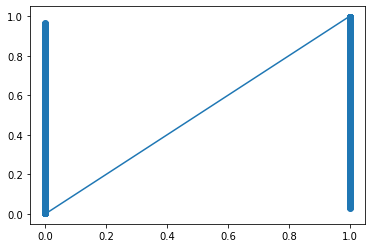

In [14]:
plt.plot(train[target], train[target])
plt.scatter(train[target], lgb_oof)

In [15]:
del train
del lgb_oof
gc.collect()

20

# Features importances

Text(0.5, 1.0, 'LGB feature importances')

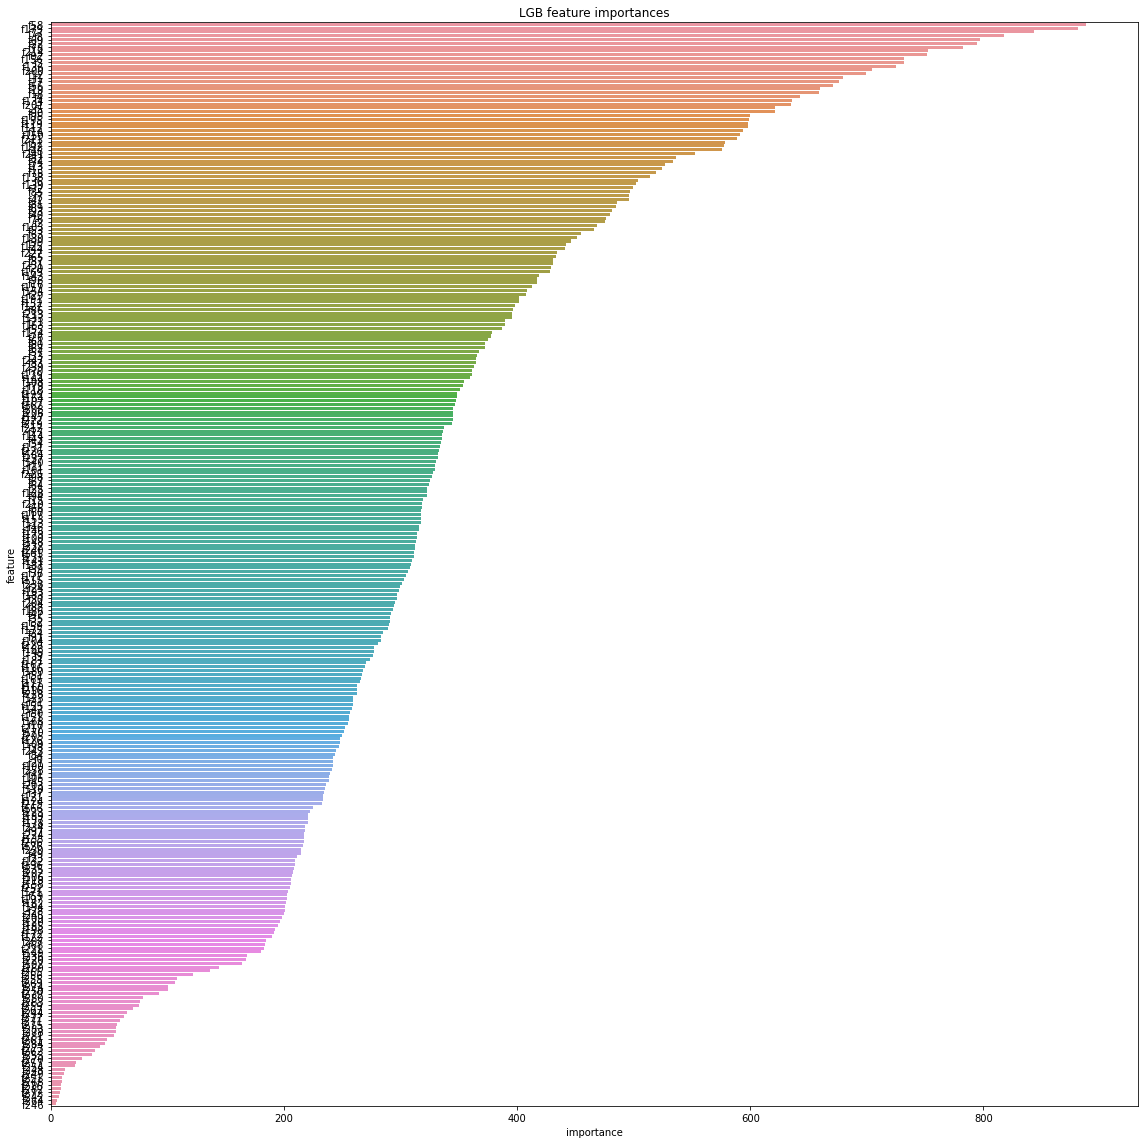

In [16]:
order = list(lgb_importances.groupby('feature').mean().sort_values('importance', ascending=False).index)

fig = plt.figure(figsize=(16, 16), tight_layout=True)
sns.barplot(x="importance", y="feature", data=lgb_importances.groupby('feature').mean().reset_index(), order=order)
plt.title("LGB feature importances")

# Submission

In [17]:
submission[target] = lgb_pred
submission.to_csv("submission.csv", index=False)

submission

,id,target
0,1000000,0.759181
1,1000001,0.247041
2,1000002,0.911101
3,1000003,0.851071
4,1000004,0.252810
...,...,...
499995,1499995,0.969206
499996,1499996,0.826848
499997,1499997,0.305398
499998,1499998,0.503591


# Log

seeds

2017 ver1
2018 ver7
2019 ver3
2020 ver11
2021 ver9